In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Market Forecasting: Forecasting Natural Gas Market Price
### Task 1:
After asking around for the source of the existing data, you learn that the current process is to take a monthly snapshot of prices from a market data provider, which represents the market price of natural gas delivered at the end of each calendar month. This data is available for roughly the next 18 months and is combined with historical prices in a time series database.
After gaining access, you are able to download the data in a CSV file. You should use this monthly snapshot to produce a varying picture of the existing price data, as well as an extrapolation for an extra year, in case the client needs an indicative price for a longer-term storage contract.

Download the monthly natural gas price data. Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024. Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future. 

Your code should take a date as input and return a price estimate. Try to visualize the data to find patterns and consider what factors might cause the price of natural gas to vary. This can include looking at months of the year for seasonal trends that affect the prices, but market holidays, weekends, and bank holidays need not be accounted for.

C:\Users\natha\AppData\Local\Temp\ipykernel_9136\2772225730.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'], index_col='Dates')


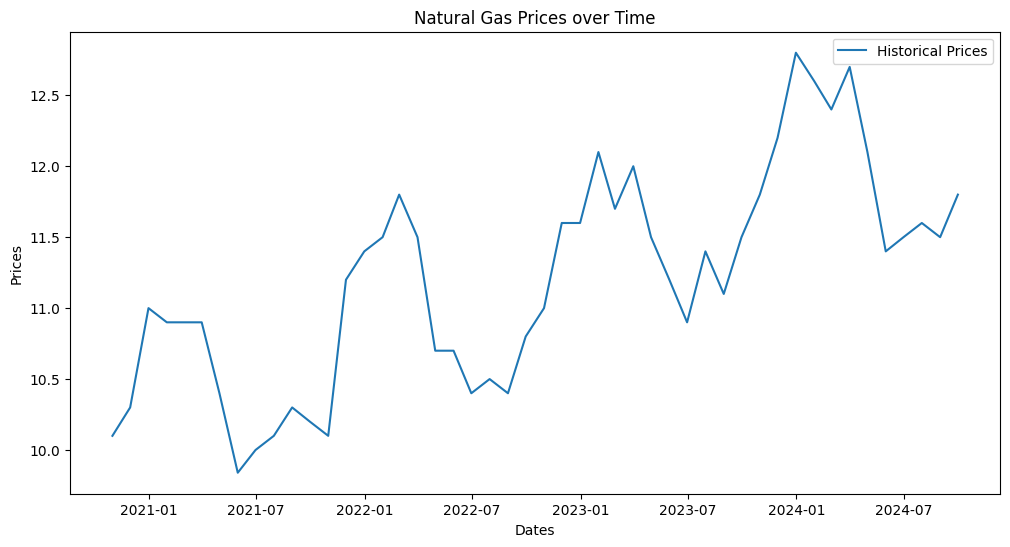

In [5]:
# Load the CSV file
df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'], index_col='Dates')

# Visualize the data to identify patterns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Prices'], label='Historical Prices')
plt.title('Natural Gas Prices over Time')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()
plt.show()

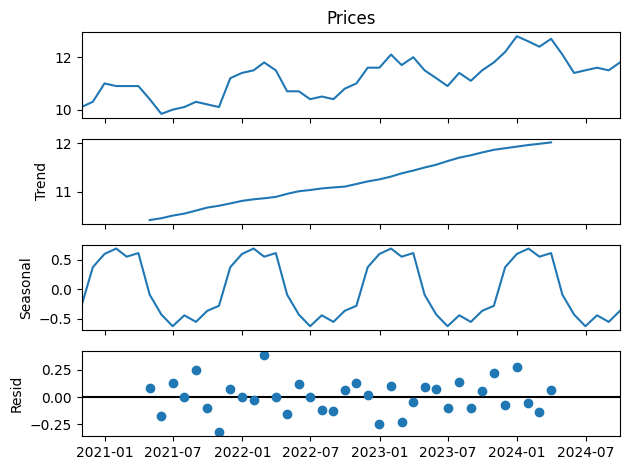

In [6]:
# Interpolate to estimate the price at any specific date within the known range
def interpolate_price(date, df):
    date = pd.to_datetime(date)
    if date < df.index.min() or date > df.index.max():
        raise ValueError("Date out of range for interpolation")

    interpolator = interpolate.interp1d(df.index.astype(int), df['Prices'], kind='linear')
    price_estimate = interpolator(date.value)
    return price_estimate

# Decompose the time series to identify trend and seasonality
decomposition = seasonal_decompose(df['Prices'], model='additive', period=12)
decomposition.plot()
plt.show()

C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


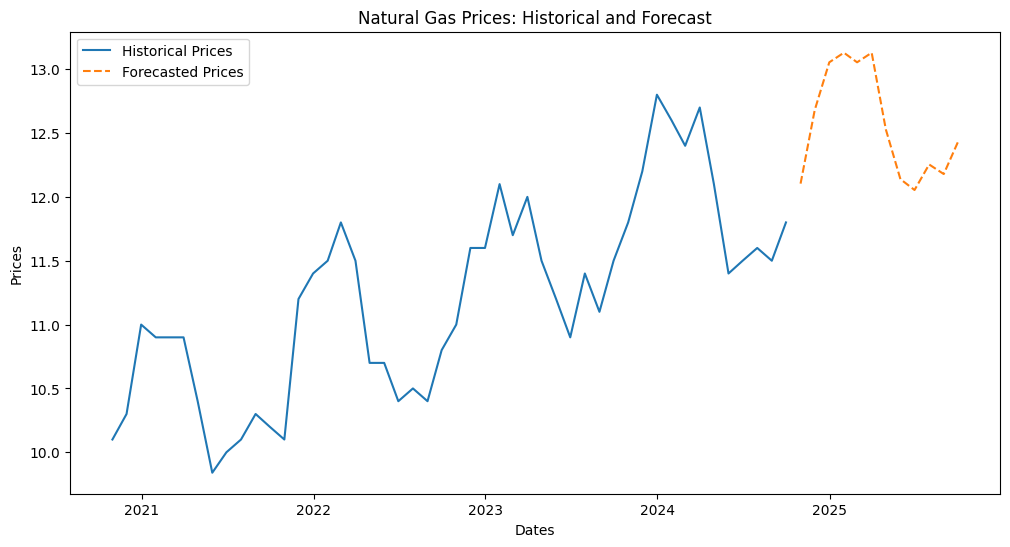

DatetimeIndex(['2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-31',
               '2025-06-30', '2025-07-31', '2025-08-31', '2025-09-30'],
              dtype='datetime64[ns]', freq='ME')


In [7]:
# Extrapolate future prices using the Holt-Winters method
# use seasonal Holt-Winters to capture trends and seasonality
model = ExponentialSmoothing(df['Prices'], trend='add', seasonal='add', seasonal_periods=12)
fitted_model = model.fit()

# Forecast for the next 12 months
forecast_periods = 12
forecast_index = pd.date_range(df.index[-1], periods=forecast_periods+1,freq='ME')[1:]
forecast = fitted_model.forecast(steps=forecast_periods)

# Plot historical prices and the forecasted future prices
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Prices'], label='Historical Prices')
plt.plot(forecast_index, forecast, label='Forecasted Prices', linestyle='--')
plt.title('Natural Gas Prices: Historical and Forecast')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()
plt.show()

# Display reference dates suitable for forecasting
print(forecast_index)

In [8]:
# Function to estimate price for any specific date
def estimate_price(date, df, model):
    date = pd.to_datetime(date)

    # If the date is within the historical data range, interpolate the price
    if date <= df.index.max():
        return interpolate_price(date, df)
    
    # If the date is in the future (beyond historical data), extrapolate using the model
    else:
        forecast_index = pd.date_range(df.index[-1], periods=forecast_periods+1,freq='ME')[1:]
        if date in forecast_index:
            return forecast[forecast_index.get_loc(date)]
        else:
            raise ValueError("Date too far in the future for current extrapolation")

# Example usage
date_input = '2025-08-31'
price_estimate = estimate_price(date_input, df, fitted_model)
print(f"Estimated natural gas price for {date_input}: {price_estimate:.2f}")

Estimated natural gas price for 2025-08-31: 12.18


C:\Users\natha\AppData\Local\Temp\ipykernel_9136\2610653359.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return forecast[forecast_index.get_loc(date)]


In [9]:
# Define new dataframe to store data including historical and forecast
df.reset_index("Dates", inplace=True)
df_new = pd.DataFrame({})
df_forecast = pd.DataFrame({"Dates": forecast.index, "Prices": forecast.values})
df_new = df._append(df_forecast)
df_new["Dates"] = df_new["Dates"].dt.date
df_new.set_index("Dates", inplace=True)

# Create new csv
df_new.to_csv("Nat_Gas_forecast.csv")